In [3]:
import os
import cv2
import numpy as np

from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

from Source.Dataset import ImageInferenceDataset
from Source.Inference import (
    bbox_to_original,
    contour_to_cv,
    contour_to_original,
    crop_padding,
    load_model,
    multi_image_collate_fn,
    stitch_tiles,
    write_result_parquet
)
   
from Source.Utils import show_sample_overlay

In [4]:
DEVICE = "cuda"
NUM_WORKERS = 1

volume_path = "D:/Datasets/W2PD17487-v2"
dataset = ImageInferenceDataset(volume_path)

loader = DataLoader(
    dataset,
    batch_size=12,       # important: variable tile counts
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=multi_image_collate_fn
)

checkpoint = "Models/PhotiLines_new_2024-10-7_21-26/2024-10-7_21-26/segmentation_model.pth"
num_classes = 1
model = load_model(checkpoint, num_classes, DEVICE)

In [5]:
def infer_batch(model, all_tiles, tile_ranges, metas, class_threshold: float = 0.9):
    all_tiles = all_tiles.to(DEVICE, non_blocking=True)
    preds = model(all_tiles)

    soft = torch.sigmoid(preds)

    for (start, end), meta in zip(tile_ranges, metas):
        preds_img = soft[start:end]

        stitched = stitch_tiles(
            preds_img,
            meta["x_steps"],
            meta["y_steps"]
        )
        stitched = crop_padding(
            stitched,
            meta["pad_x"],
            meta["pad_y"]
        )

        binary = (stitched > class_threshold).to(torch.uint8) * 255
        mask_np = binary.squeeze(0).cpu().numpy()

        contours, _ = cv2.findContours(
                mask_np,
                cv2.RETR_LIST,
                cv2.CHAIN_APPROX_SIMPLE
            )


        result = {
            "image_name": meta["image_name"],
            "image_width": meta["orig_shape"][1],
            "image_height": meta["orig_shape"][0],
            "num_contours": len(contours),
            "contours": [
                contour_to_original(
                    [(int(x), int(y)) for [[x, y]] in cnt],
                    meta["scale_x"],
                    meta["scale_y"],
                )
                for cnt in contours
            ],
            "bboxes": [
                bbox_to_original(
                    cv2.boundingRect(cnt),
                    meta["scale_x"],
                    meta["scale_y"],
                )
                for cnt in contours
            ],
        }

        return result

In [6]:
class_threshold = 0.85
results = []

with torch.no_grad():
    all_tiles, tile_ranges, metas = next(iter(loader))
    result = infer_batch(model, all_tiles, tile_ranges, metas, class_threshold)
    results.append(result)
        

In [7]:
parquet_out = os.path.join(volume_path, "parquet_out")

for r in results:
    write_result_parquet(r, out_dir=parquet_out)

In [ ]:
### run on entire directory
torch.cuda.synchronize()
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

class_threshold = 0.85
results = []

with torch.no_grad():
    for all_tiles, tile_ranges, metas in tqdm(loader, total=len(loader)):
        result = infer_batch(model, all_tiles, tile_ranges, metas, class_threshold)
        results.append(result)
    
end.record()
torch.cuda.synchronize()

print(f"Processed {len(dataset)} images")
print(f"Elapsed Inference time: {start.elapsed_time(end) / 1000:.2f}s")

parquet_out = os.path.join(volume_path, "parquet_out")

for _, res in tqdm(enumerate(results), total=len(results)):
    write_result_parquet(r, out_dir=parquet_out)

In [15]:
# debug results
res_idx = 12
orig_img_path = os.path.join(volume_path, results[res_idx]["image_name"])
orig_img = cv2.imread(orig_img_path)

prev_mask = np.zeros(shape=(results[res_idx]["image_height"], results[res_idx]["image_width"]), dtype=np.uint8)
contours_cv = [contour_to_cv(c) for c in results[res_idx]["contours"]]

for idx, _ in enumerate(contours_cv):
    cv2.drawContours(prev_mask, contours_cv, contourIdx=idx, color=(255, 255, 255), thickness=-1)

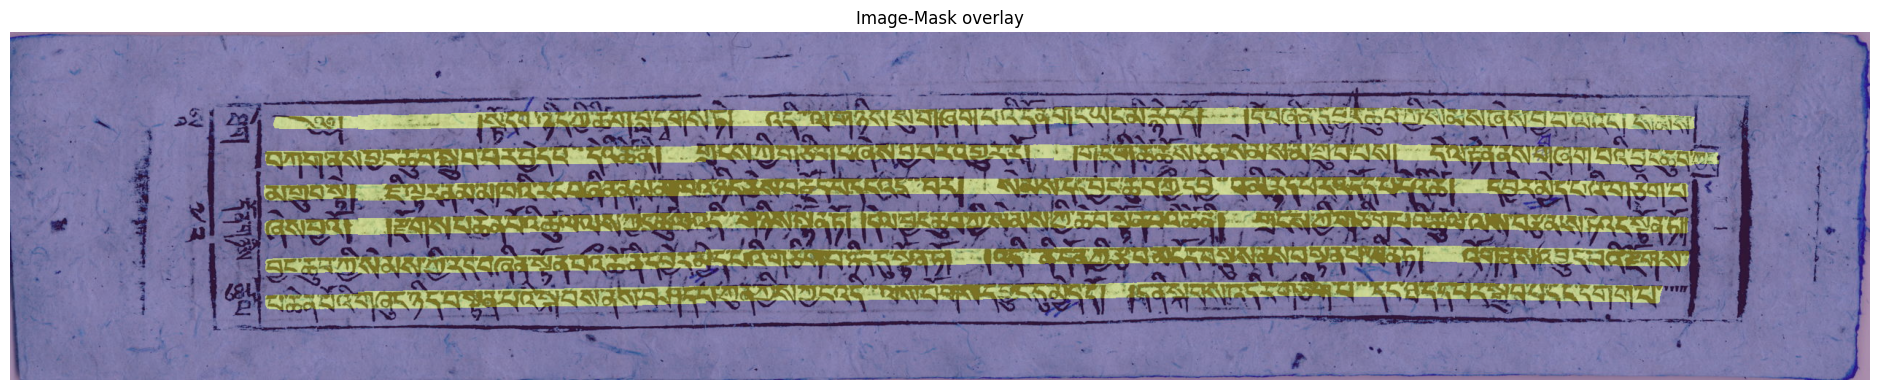

In [16]:
show_sample_overlay(orig_img, prev_mask)